# Aarhus: Now with constraints

In this notebook we check if using the constraint that the cost of booking a room should be higher than that of keeping it on hold produces a more useful machine learning model.

Comments:
- There are duplicates. I have decided to keep the last of the duplicates, assuming its the right information
- There is info on the rooms in S.03 only for one day, so I have dropped them.
- I have dropped all rows for which I did not have information for all the rooms. This leaves me with 1320 rows, which are 55 days. The rest of 2022 has been discarded.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from thermo.utils.time import is_schoolday

In [2]:
bookings = pd.read_csv("../assets/Booking.csv").loc[lambda x: x["MUNICIPALITY"].eq("Aarhus")].drop_duplicates(subset="MUNICIPALITY_DATE_TIME_ROOM", keep='last')

In [3]:
bookings

,ROOM_ID,DATO,TIME,BOOKED,MUNICIPALITY_DATE_TIME_ROOM,MUNICIPALITY,SCHOOL
19,01.S.37,2022-08-09,18:00:00,1,09-08-2022-18:00:00-01.S.37-Aarhus,Aarhus,Strandskolen
20,08.S.02,2022-08-09,18:00:00,1,09-08-2022-18:00:00-08.S.02-Aarhus,Aarhus,Strandskolen
21,06.S.02,2022-08-09,18:00:00,1,09-08-2022-18:00:00-06.S.02-Aarhus,Aarhus,Strandskolen
31,01.S.29,2022-08-09,18:00:00,0,09-08-2022-18:00:00-01.S.29-Aarhus,Aarhus,Strandskolen
39,08.S.02,2022-08-09,19:00:00,1,09-08-2022-19:00:00-08.S.02-Aarhus,Aarhus,Strandskolen
...,...,...,...,...,...,...,...
144969,01.S.37,2022-12-26,21:00:00,0,26-12-2022-21:00:00-01.S.37-Aarhus,Aarhus,Strandskolen
144974,09.S.04,2022-12-26,22:00:00,0,26-12-2022-22:00:00-09.S.04-Aarhus,Aarhus,Strandskolen
144981,01.S.37,2022-12-26,22:00:00,0,26-12-2022-22:00:00-01.S.37-Aarhus,Aarhus,Strandskolen
144988,01.S.37,2022-12-26,23:00:00,0,26-12-2022-23:00:00-01.S.37-Aarhus,Aarhus,Strandskolen


In [4]:
bookings["ROOM_ID"].value_counts()

ROOM_ID
01.S.29    5616
01.S.01    4752
01.S.02    3816
06.S.02    3576
01.S.37    3264
09.S.04    2664
08.S.02    1560
08.S.05    1512
03.S.04      24
03.S.05      24
03.S.03      24
Name: count, dtype: int64

In [5]:
dataf = pd.pivot_table(
    data = bookings.loc[lambda x: ~x["ROOM_ID"].str.startswith('03')].assign(datetime= lambda d: pd.to_datetime(d["DATO"] + " " + d["TIME"])),
    index = "datetime",
    columns = "ROOM_ID",
    values = "BOOKED"
).dropna().astype(int)

In [6]:
dataf

ROOM_ID,01.S.01,01.S.02,01.S.29,01.S.37,06.S.02,08.S.02,08.S.05,09.S.04
datetime,,,,,,,,
2022-01-04 00:00:00,0,0,0,0,0,0,0,0
2022-01-04 01:00:00,0,0,0,0,0,0,0,0
2022-01-04 02:00:00,0,0,0,0,0,0,0,0
2022-01-04 03:00:00,0,0,0,0,0,0,0,0
2022-01-04 04:00:00,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2022-12-20 19:00:00,0,0,0,1,1,1,1,1
2022-12-20 20:00:00,0,0,1,0,0,0,0,0
2022-12-20 21:00:00,0,0,0,0,0,0,0,0


Keep only the hours for extracurricular

In [7]:
v_schoolday = np.vectorize(is_schoolday)
dataf = dataf.loc[
    ((v_schoolday(dataf.index.date)) & (dataf.index.hour >=15)) | 
    ((~v_schoolday(dataf.index.date)) & (dataf.index.hour >=8))]

In [8]:
dataf

ROOM_ID,01.S.01,01.S.02,01.S.29,01.S.37,06.S.02,08.S.02,08.S.05,09.S.04
datetime,,,,,,,,
2022-01-04 15:00:00,0,0,0,0,0,0,0,0
2022-01-04 16:00:00,0,0,0,0,0,0,1,0
2022-01-04 17:00:00,1,0,1,1,1,1,1,1
2022-01-04 18:00:00,0,0,0,0,1,1,1,1
2022-01-04 19:00:00,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...
2022-12-20 19:00:00,0,0,0,1,1,1,1,1
2022-12-20 20:00:00,0,0,1,0,0,0,0,0
2022-12-20 21:00:00,0,0,0,0,0,0,0,0


## Ventilation system

In [9]:
day_night = dataf.assign(date=lambda d: d.index.date).groupby("date").apply(lambda x: x.iloc[::-1, :].cummax().iloc[::-1, :]).drop(columns="date").reset_index(level=0).drop(columns="date")

In [10]:
X = day_night.add(dataf).applymap(lambda x: {0:"night", 1: "day", 2: "booked"}[x])

/tmp/ipykernel_18472/1483381304.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = day_night.add(dataf).applymap(lambda x: {0:"night", 1: "day", 2: "booked"}[x])


In [11]:
X.tail(24)

ROOM_ID,01.S.01,01.S.02,01.S.29,01.S.37,06.S.02,08.S.02,08.S.05,09.S.04
datetime,,,,,,,,
2022-12-13 18:00:00,day,day,booked,night,booked,booked,booked,booked
2022-12-13 19:00:00,day,day,day,night,night,booked,booked,booked
2022-12-13 20:00:00,day,day,booked,night,night,night,night,night
2022-12-13 21:00:00,booked,booked,night,night,night,night,night,night
2022-12-13 22:00:00,night,night,night,night,night,night,night,night
2022-12-13 23:00:00,night,night,night,night,night,night,night,night
2022-12-15 15:00:00,day,day,day,booked,day,booked,day,booked
2022-12-15 16:00:00,day,day,day,booked,day,booked,booked,day
2022-12-15 17:00:00,day,day,day,booked,booked,booked,booked,booked


## Targets

In [12]:
energy = pd.read_csv("../assets/Energy.csv").dropna().loc[lambda x: x["MUNICIPALITY"].eq("Aarhus")].loc[lambda x: x["MEASURE_TYPE"].eq("electricity")].loc[lambda x: x["DATO"].str.startswith("2022")].loc[lambda x: x["MEASURE_POINT"].mod(2).eq(0)].drop_duplicates(["DATO", "TIME"], keep="last")

In [13]:
energy

,MEASURE_POINT,DATO,MEASURE_TYPE,VALUE,UNIT,TIME,MUNICIPALITY_DATE,MUNICIPALITY,SCHOOL
28625,3261220102,2022-01-01,electricity,9.72,kWh,23:00:00,2022-01-01-Aarhus,Aarhus,Strandskolen
28626,3261220102,2022-01-02,electricity,9.48,kWh,00:00:00,2022-01-02-Aarhus,Aarhus,Strandskolen
28627,3261220102,2022-01-02,electricity,9.54,kWh,01:00:00,2022-01-02-Aarhus,Aarhus,Strandskolen
28628,3261220102,2022-01-02,electricity,9.42,kWh,02:00:00,2022-01-02-Aarhus,Aarhus,Strandskolen
28629,3261220102,2022-01-02,electricity,9.48,kWh,03:00:00,2022-01-02-Aarhus,Aarhus,Strandskolen
...,...,...,...,...,...,...,...,...,...
37357,3261220102,2022-12-31,electricity,7.74,kWh,21:00:00,2022-12-31-Aarhus,Aarhus,Strandskolen
37358,3261220102,2022-12-31,electricity,7.86,kWh,22:00:00,2022-12-31-Aarhus,Aarhus,Strandskolen
37359,3261220102,2022-12-31,electricity,7.98,kWh,23:00:00,2022-12-31-Aarhus,Aarhus,Strandskolen
37382,3261220102,2022-12-21,electricity,22.14,kWh,18:00:00,2022-12-21-Aarhus,Aarhus,Strandskolen


In [14]:
electricity = energy.set_index(pd.to_datetime(energy["DATO"] + " " + energy["TIME"]))[["VALUE"]]

In [15]:
electricity

,VALUE
2022-01-01 23:00:00,9.72
2022-01-02 00:00:00,9.48
2022-01-02 01:00:00,9.54
2022-01-02 02:00:00,9.42
2022-01-02 03:00:00,9.48
...,...
2022-12-31 21:00:00,7.74
2022-12-31 22:00:00,7.86
2022-12-31 23:00:00,7.98
2022-12-21 18:00:00,22.14


In [16]:
y = electricity.loc[X.index]

## Machine Learning

### Constrained Ridge regression:
Using quadratic programming it is possible to add the constraint that the the costs for `_booked` rooms should be equal or higher than the cost of `_day` rooms, which would make sense from the bussiness case.

Here is the code that lets us build such a model

In [17]:
import cvxpy as cp  # Quadratic programming
from numpy.typing import NDArray
from scipy import sparse
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.exceptions import FitFailedWarning
from sklearn.utils.validation import check_is_fitted

In [18]:
class ConstrainedRidge(RegressorMixin, BaseEstimator):
    def __init__(
        self,
        alpha: float = 1.0,
        G: NDArray | None = None,
        h: NDArray | None = None,
        A: NDArray | None = None,
        b: NDArray | None = None,
    ):
        """
        Minimizes the mean squared error with regularization alpha under constraints:
        G @ w >= h
        A @ w == b
        """
        self.alpha = alpha
        self.G = G
        self.h = h
        self.A = A
        self.b = b

    @staticmethod
    def _validate_constraints(A: NDArray, b: NDArray) -> None:
        if len(A.shape) != 2:
            raise ValueError(
                f"G must be a 2D numpy array, but shape {A.shape} was given."
            )
        if b is not None:  # if b is ambiguous
            if len(b.shape) != 1:
                raise ValueError(
                    f"G must be a 1D numpy array, but shape {b.shape} was given."
                )
            elif b.shape[0] != A.shape[0]:
                raise ValueError(
                    f"The dimensions of G {A.shape} and h {b.shape} do not match."
                )
            else:
                return b
        else:
            return np.zeros(A.shape[0])

    def fit(self, X: NDArray, y: NDArray) -> "ConstrainedRidge":
        y = y.to_numpy().flatten()

        # Add a 1 padding to X to model for intercept
        if isinstance(X, sparse.csr_matrix):
            X_ = sparse.hstack((X, np.ones((X.shape[0], 1))))
        else:
            X_ = np.c_[X, np.ones(X.shape[0])]

        # Define variables for Quadratic programming
        w = cp.Variable(X_.shape[1])
        P = X_.T @ X_
        P += self.alpha * np.eye(P.shape[0])  # L2 regularization
        q = X_.T @ y

        # Constraints
        constraints = []
        if self.G is not None:  # if G is ambiguous
            self.h = self._validate_constraints(self.G, self.h)
            constraints.append(self.G @ w >= self.h)
        if self.A is not None:
            self.b = self._validate_constraints(self.A, self.b)
            constraints.append(self.A @ w == self.b)

        # Quadratic programming problem
        problem = cp.Problem(
            cp.Minimize(0.5 * cp.quad_form(w, P) - q.T @ w), constraints
        )
        problem.solve()

        self.status_ = problem.status

        # Extract coefficients
        if self.status_ == "optimal":
            self.fitted_ = True
        else:
            self.fitted_ = False
            msg = (
                "cvxpy failed to solve quadratic programming problem,"
                f" with status {self.status_}"
            )
            raise FitFailedWarning(msg)

        self.coef_ = w.value[:-1]
        self.intercept_ = w.value[-1]

        return self

    def predict(self, X: NDArray) -> NDArray:
        check_is_fitted(self, "fitted_")
        return X @ self.coef_ + self.intercept_


### Training the model

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline

In [20]:
# shuffle
rng = np.random.default_rng(42)
idx = rng.permutation(X.index)
X = X.loc[idx]
y = y.loc[idx]

In [21]:
N = X.shape[1]
G = np.eye(2 * N+1)
G[:-1:2,1::2] = - np.eye(N)

In [22]:
model = Pipeline(steps=[
    ("one_hot_encoder", OneHotEncoder(drop=["night"]*X.shape[1])),
    ("linear_regression", ConstrainedRidge(G=G, alpha=0.1)),
])

In [23]:
list(filter(lambda x: x.startswith("linear"), model.get_params()))

['linear_regression',
 'linear_regression__A',
 'linear_regression__G',
 'linear_regression__alpha',
 'linear_regression__b',
 'linear_regression__h']

In [24]:
nfolds = 5
cv = GridSearchCV(
    estimator=model,
    param_grid={"linear_regression__alpha":10**np.linspace(np.log10(0.001), np.log10(100),21, endpoint=True)},
    cv=nfolds,
    scoring="r2",
    return_train_score=True,
    n_jobs=-1
)

In [25]:
cv.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('one_hot_encoder',
                                        OneHotEncoder(drop=['night', 'night',
                                                            'night', 'night',
                                                            'night', 'night',
                                                            'night',
                                                            'night'])),
                                       ('linear_regression',
                                        ConstrainedRidge(G=array([[ 1., -1.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0.,
        -0.,  0., -0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0., -0.,  1., -1.,  0., -0.,  0., -0.,  0., -0.,  0.,...
             param_grid={'linear_regression__alpha': array([1.00000000e-03, 1.77827941e-03, 3.16227766e-03, 5.62341325e-03,
       1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
       1.00000000e+02])},
             return_train_score=True, scoring='r2')

In [26]:
scores = pd.DataFrame(cv.cv_results_)

In [27]:
scores["param_linear_regression__alpha"].value_counts()

param_linear_regression__alpha
0.001                    1
0.0017782794100389228    1
0.0031622776601683794    1
0.005623413251903491     1
0.01                     1
0.01778279410038923      1
0.03162277660168379      1
0.056234132519034905     1
0.09999999999999999      1
0.1778279410038923       1
0.31622776601683794      1
0.5623413251903491       1
1.0                      1
1.7782794100389228       1
3.162277660168379        1
5.62341325190349         1
10.0                     1
17.78279410038923        1
31.622776601683796       1
56.23413251903491        1
100.0                    1
Name: count, dtype: int64

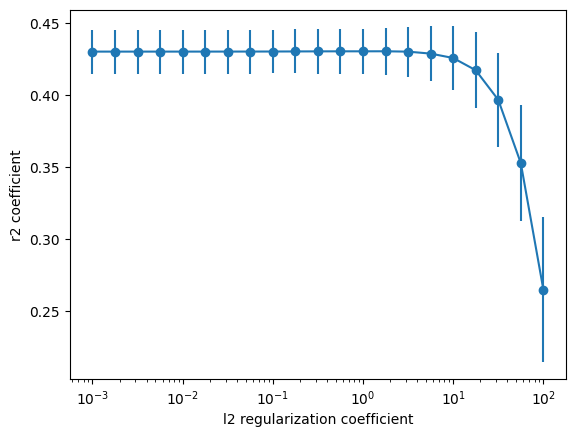

In [28]:
plt.errorbar(scores["param_linear_regression__alpha"], scores["mean_test_score"], yerr=scores["std_test_score"]/np.sqrt(nfolds), fmt="o-")
plt.xscale("log")
plt.xlabel("l2 regularization coefficient")
plt.ylabel("r2 coefficient")
plt.show()

In [29]:
cv.best_params_  

{'linear_regression__alpha': 1.7782794100389228}

In [30]:
best = scores.iloc[cv.best_index_]
print(f"Best test r2 score: {best['mean_test_score'].round(2)} +- {(2*best['std_test_score']/np.sqrt(nfolds)).round(2)}")
print(f"Best train r2 score: {best['mean_train_score'].round(3)} +- {(2*best['std_train_score']/np.sqrt(nfolds)).round(3)}")

Best test r2 score: 0.43 +- 0.03
Best train r2 score: 0.45 +- 0.007


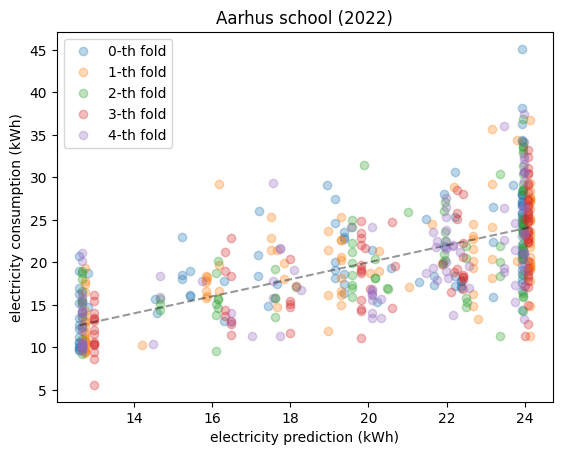

In [31]:
# validate
kfold = KFold(5)
xmin=1000
xmax=0
for i, (idx_train, idx_test) in enumerate(kfold.split(X, y)):
    model.set_params(**cv.best_params_)
    model.fit(X.iloc[idx_train], y.iloc[idx_train])
    y_pred = model.predict(X.iloc[idx_test])
    plt.plot(y_pred, y.iloc[idx_test], 'o', alpha=0.3, label=f"{i}-th fold")
    xmin = min((xmin, y_pred.min()))
    xmax = max((xmax, y_pred.max()))
x = np.linspace(xmin, xmax, 100)
plt.plot(x, x, "k--", alpha=0.4)
plt.xlabel("electricity prediction (kWh)")
plt.ylabel("electricity consumption (kWh)")
plt.title("Aarhus school (2022)")
plt.legend()
plt.show()

In [32]:
costs = (
    pd.DataFrame(data={"cost":cv.estimator.steps[-1][-1].coef_, "name":cv.estimator.steps[0][-1].get_feature_names_out()})
    .assign(room=lambda x: x.name.str.split("_").str[0])
    .assign(status=lambda x: x.name.str.split("_").str[1])
    .drop(columns="name")
    .pivot_table(index="room", columns="status")
)

In [33]:
costs.columns = costs.columns.droplevel()

In [34]:
costs.apply(lambda x: x.round(2))

status,booked,day
room,,
01.S.01,1.81,1.81
01.S.02,1.99,1.99
01.S.29,0.52,0.52
01.S.37,0.24,0.24
06.S.02,3.06,3.06
08.S.02,1.41,1.41
08.S.05,0.00,0.00
09.S.04,2.25,2.25
